# Lets create a Recommendation system for the Henry coefficients of porous materials

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import scipy
import matplotlib

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [2]:
henry_df = pd.read_csv('data/henry_matrix_df.csv')
henry_df.set_index(list(henry_df)[0], inplace=True)
henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,CSCPPACGZOOCGX-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,NNPPMTNAJDCUHE-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.629264,0.093669,0.281977,NaN,12.491789,14.853234,0.001506,3.453911,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185.391888,14.544057,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,24.354551,0.613339,0.872527,0.106368,52.095266,28.917304,NaN,NaN,NaN,NaN,...,NaN,73.780117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.28579
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1.904248,0.367793,0.144679,0.188161,NaN,NaN,NaN,3.885899,NaN,NaN,...,1.962697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,2.351403,0.240774,0.694406,0.012683,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550.136881,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.518690,0.271622,0.662727,0.281226,338.906107,1.435443,86.774658,0.191440,20.891916,NaN,...,NaN,0.458529,424.158566,NaN,NaN,NaN,NaN,NaN,21.673068,NaN
NIST-MATDB-9f02824618e94d86caedc9fb497366ba,0.277908,NaN,0.003670,NaN,NaN,NaN,11.184831,4.954988,NaN,NaN,...,NaN,186.424362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,3.040278,NaN,14.129264,NaN,NaN,NaN,55.918160,7.839381,1.624875,0.897025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.762227,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1.046942,0.167755,0.368107,NaN,NaN,0.140726,1.156674,0.076167,2.704463,0.826928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.695828,NaN
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,2.691466,0.253165,0.695229,0.127311,NaN,NaN,NaN,0.780053,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

## Lets also define a function that will randomly split our data into <i>k</i> folds

In [4]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, -1, dtype=np.int)
    all_k_folds_not_represented_in_each_column = True
    n_iteration = 0
    while all_k_folds_not_represented_in_each_column:
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.random.randint(0, k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            unique_folds = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(unique_folds) <= k:
                all_k_folds_not_represented_in_each_column = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_iteration > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_iteration))
    return fold_matrix

fold_matrix = k_fold_split(henry_df, 3, max_iter=1e5)

Number of iterations required to split data into 3-folds: 221


In [5]:
def sort_matrix_by_freq(material_gas_matrix):
    row_sum = np.sum(material_gas_matrix, axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(material_gas_matrix[new_row_order, :], axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return material_gas_matrix[new_row_order, :][:, new_col_order]

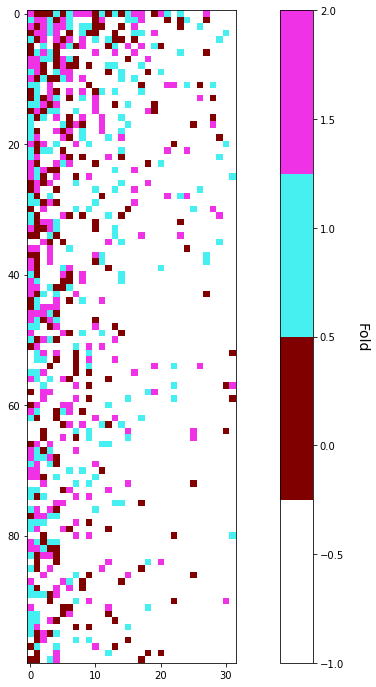

In [6]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
#my_cmap = matplotlib.cm.get_cmap('Accent')
mycmap = matplotlib.colors.ListedColormap(np.array([[255/255, 255/255, 255/255, 1], 
                                                    [128/255, 0, 0, 1], 
                                                    [70/255, 240/255, 240/255, 1], 
                                                    [240/255, 50/255, 230/255, 1],
                                                    [60/255, 180/255, 75/255, 1],
                                                    [245/255, 130/255, 48/255, 1]][:len(np.unique(fold_matrix))]))
plt.imshow(sort_matrix_by_freq(fold_matrix), interpolation='none', cmap=mycmap)
cbar = plt.colorbar()
cbar.set_label('Fold', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')

plt.show()

In [8]:
henry_df.mask(fold_matrix != 0).values

array([[ 0.62926413,         nan,         nan, ...,         nan,
        14.54405722,         nan],
       [24.35455115,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,  0.14467866, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

### Lets start setting up the Recommender System algorithm

#### ALS methods implemented according to http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

In [9]:
def predict(x, y, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + (x.T).dot(y)

In [10]:
def predict_all(X, Y, mu):
    predictions = np.zeros((X.shape[1], Y.shape[1]))
    for u in range(X.shape[1]):
        for i in range(Y.shape[1]):
            predictions[u, i] = predict(X[:,u], Y[:,i], mu)
    return predictions

In [31]:
def ALS(henry_matrix, f, lambd, threshold, convergence=1e-6, maxiter=20000, verbose=True):
    assert len(lambd) == 2, "There should be two lambda values, one for each latent matrix"
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    
    #M = np.random.rand(f, henry_matrix.shape[0])
    #G = np.random.rand(f, henry_matrix.shape[1])
    M = np.random.rand(f+2, henry_matrix.shape[0])-0.5
    G = np.random.rand(f+2, henry_matrix.shape[1])-0.5
    M[-2,:] = 1.0
    G[-1,:] = 1.0
    if verbose:
        print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for j in range(M.shape[1]):
            mask = ~np.isnan(henry_matrix[j,:])
            #M[:,j] = ((henry_matrix[j,:][mask]).dot(G[:,mask].T)).dot(np.linalg.inv(G[:,mask].dot(G[:,mask].T) + lambd[0] * np.identity(f+2)))
            b = G[:,mask].dot(henry_matrix[j,:][mask].T)
            A = (G[:,mask].dot(G[:,mask].T) + lambd[0] * np.identity(f+2)).T
            M[:,j] = np.linalg.solve(A,b)
            M[-2,j] = 1.0
        for j in range(G.shape[1]):
            mask = ~np.isnan(henry_matrix[:,j])
            #G[:,j] = np.linalg.inv(M[:,mask].dot(M[:,mask].T) + lambd[1] * np.identity(f+2)).dot(M[:,mask]).dot(henry_matrix[:,j][mask])
            b = M[:,mask].dot(henry_matrix[:,j][mask])
            A = M[:,mask].dot(M[:,mask].T) + lambd[1] * np.identity(f+2)
            G[:,j] = np.linalg.solve(A,b)
            G[-1,j] = 1.0
            
        pred = predict_all(M, G, 0.0)[~np.isnan(henry_matrix)].flatten()
        actual = henry_matrix[~np.isnan(henry_matrix)].flatten()
        #print(pred)
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n % 1000 == 0:
            if verbose:
                print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 499:
                if verbose:
                    print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                    print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            print('Maximum number of iterations ({}) reached.'.format(maxiter))
            break
        if np.count_nonzero(np.isnan(M)) > 0 or np.count_nonzero(np.isnan(G)) > 0:
            raise Exception('NaN encountered in either latent representation')
    
    if verbose:
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Train Loss')
        plt.grid('on')
        plt.tight_layout()
        plt.show()
    
    return M, G, train_error

In [47]:
def cross_validation(henry_df, k, rs, lambd1s, lambd2s):
    min_test_error = np.inf
    best_U = np.array([])
    best_V = np.array([])
    for r in rs:
        for lambd1 in lambd1s:
            for lambd2 in lambd2s:
                print('-----------------------------------------\nStarting ALS with the following parameters:\nr = {}, lambda = [{:.2f}, {:.2f}]'.format(r, lambd1, lambd2))
                test_errors = []
                Us = []
                Vs = []
                fold_matrix = k_fold_split(henry_df, k)
                log_henries = henry_df.copy()
                mask = np.greater(log_henries, 0., where=~np.isnan(log_henries))
                log_henries[mask] = np.log(log_henries[mask])
                for test_fold in range(k):
                    U,V, train_error = ALS(log_henries.mask(fold_matrix != test_fold).values, r, [lambd1, lambd2], 1e-5, 1e-6, 5000, False)
                    pred = U.T.dot(V)[fold_matrix == test_fold].flatten()
                    actual = log_henries.values[fold_matrix == test_fold].flatten()
                    test_errors.append(np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(actual))])/len(actual)))
                    Us.append(U)
                    Vs.append(V)
                test_error = np.mean(test_errors)
                print('Test Error: {:.3f}'.format(test_error))
                #print('Test Errors:\n\t{:.2f}\n\t{:.2f}\n\t{:.2f}\n'.format(test_errors[0], test_errors[1], test_errors[2]))
                if test_error < min_test_error:
                    min_test_error = test_error
                    print('\n^^^^^^^^^^^^^^^^^^^\n')
                    best_fold = np.argmin(test_errors)
                    best_U = np.copy(Us[best_fold])
                    best_V = np.copy(Vs[best_fold])
    return best_U, best_V

rs = [5]
lambd1s = [0.1]
lambd2s = [0.05]
best_U, best_V = cross_validation(henry_df, 3, rs, lambd1s, lambd2s)
            

-----------------------------------------
Starting ALS with the following parameters:
r = 5, lambda = [0.10, 0.05]
Number of iterations required to split data into 3-folds: 3
Maximum number of iterations (5000) reached.
Maximum number of iterations (5000) reached.
Maximum number of iterations (5000) reached.
Test Error: 0.076

^^^^^^^^^^^^^^^^^^^



In [48]:
best_U.shape

(7, 100)

In [52]:
h = np.exp(best_U.T.dot(best_V))
test_set = henry_df.values.flatten()
non_nan_mask = ~np.isnan(test_set)
prediction = h.flatten()
test_error_from_recsys = np.sqrt(np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]])/len(prediction[non_nan_mask]))
test_error_from_recsys

3344.6824120554015

In [53]:
means = np.nanmean(henry_df.values, axis=0)
prediction = np.zeros(henry_df.shape)
for (i, mean_i) in enumerate(means):
    prediction[:, i] = mean_i
prediction = prediction.flatten()
test_error_from_gas_avg = np.sqrt(np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]])/len(prediction[non_nan_mask]))
test_error_from_gas_avg

3650.234264745106

In [54]:
means = np.nanmean(henry_df.values, axis=1)
prediction = np.zeros(henry_df.shape)
for (i, mean_i) in enumerate(means):
    prediction[i, :] = mean_i
prediction = prediction.flatten()
test_error_from_mof_avg = np.sqrt(np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]])/len(prediction[non_nan_mask]))
test_error_from_mof_avg

3647.7138071913264

In [55]:
def sort_df_by_freq(df):
    row_sum = np.sum(~np.isnan(df.values), axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(~np.isnan(df.values[new_row_order, :]), axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return new_row_order, new_col_order
new_row_order, new_col_order = sort_df_by_freq(henry_df)

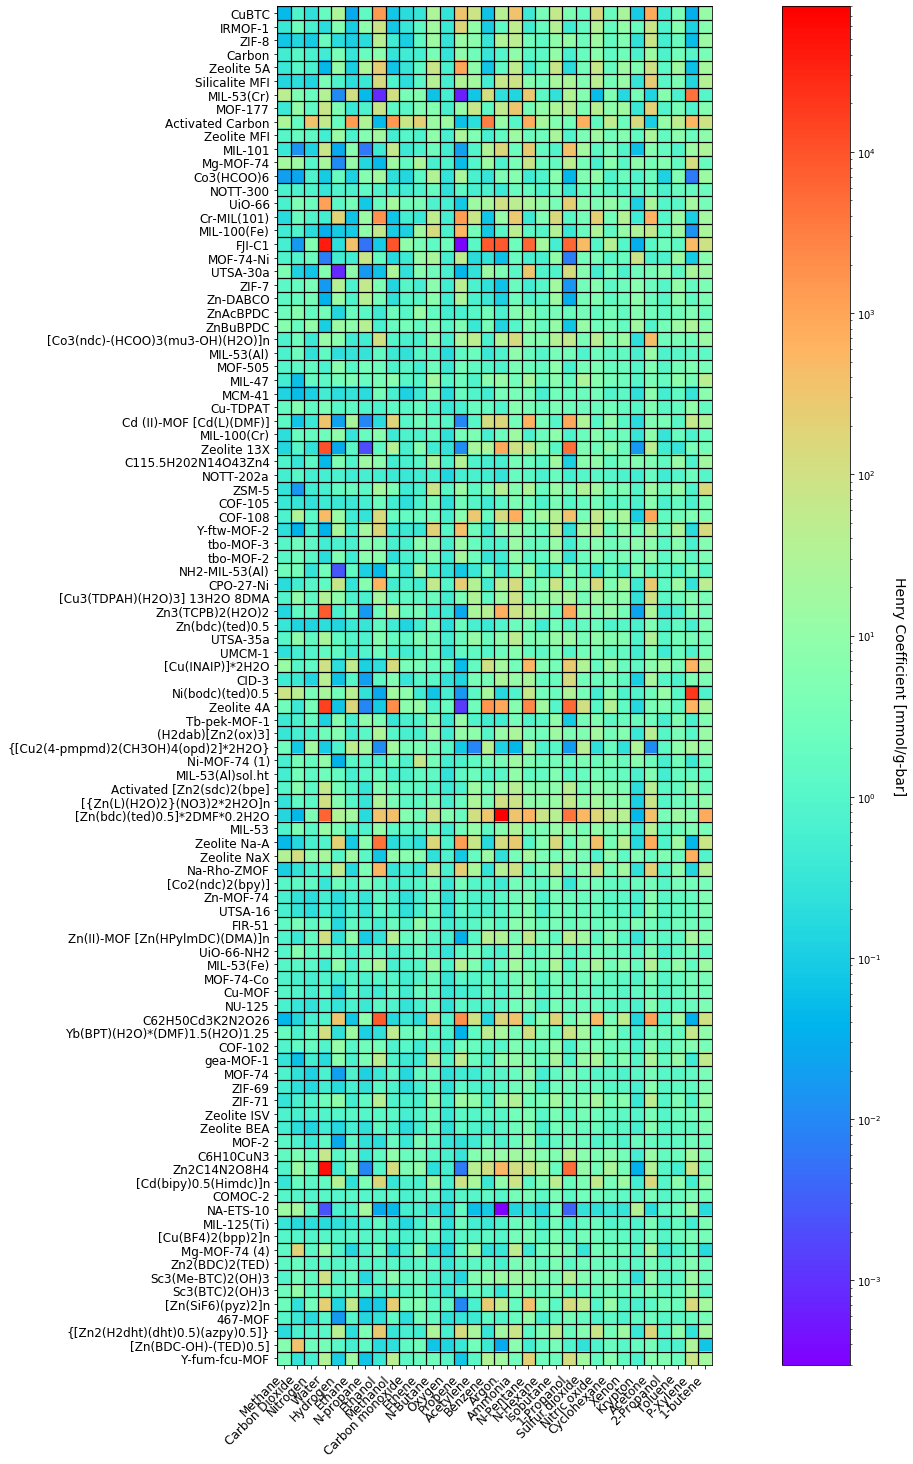

In [56]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

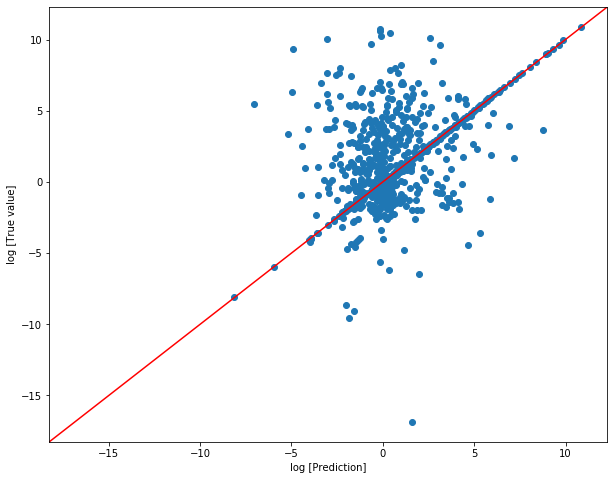

In [57]:
def parity_plot(actual, prediction):
    fig, ax = plt.subplots(figsize=(10,8))
    
    prediction = prediction.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    #ax.hexbin(prediction[mask], actual[mask], gridsize=50)
    ax.scatter(prediction[mask], actual[mask])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = xlim
    if xlim[1] < ylim[1]:
        lim = ylim
    ax.plot(lim, lim, c='r')
    ax.set_xlabel('log [Prediction]')
    ax.set_ylabel('log [True value]')
    #lim = [-7, 9]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax2 = fig.add_axes([0.175, 0.625, 0.25, 0.25])
    ax2.scatter(prediction[mask], actual[mask])
    ax2.plot(lim, lim, c='r')
    ax2.set_xlim([-5, 5])
    ax2.set_ylim([-5, 5])
    
    plt.show()
    
log_henries = henry_df.copy()
mask = np.greater(log_henries, 0., where=~np.isnan(log_henries))
log_henries[mask] = np.log(log_henries[mask])
parity_plot(log_henries, best_U.T.dot(best_V))

In [67]:
h = np.exp(best_U.T.dot(best_V))
test_set = henry_df.values.flatten()
non_nan_mask = ~np.isnan(test_set)
prediction = h.flatten()
test_error_from_recsys = np.sqrt(np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]])/len(prediction[non_nan_mask]))
test_mean = np.nanmean(test_set)

R_squared = 1 - np.sum([(test_set[i] - prediction[i])**2 for i in np.arange(len(prediction))[non_nan_mask]]) / np.sum([(test_set[i] - test_mean)**2 for i in np.arange(len(prediction))[non_nan_mask]])
print(r'R_squared = {:.3f}'.format(R_squared))

R_squared = 0.319


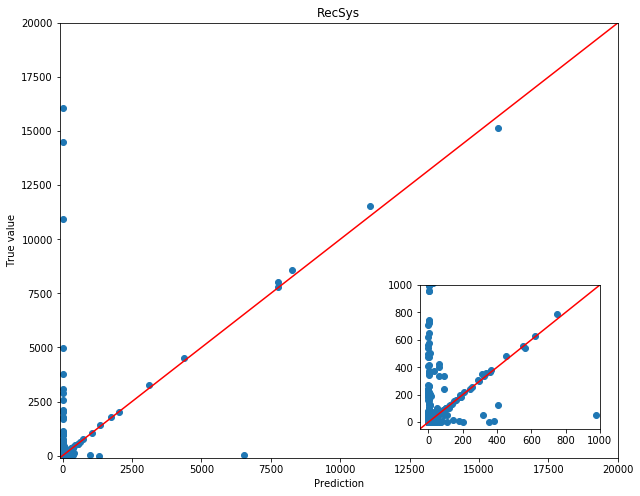

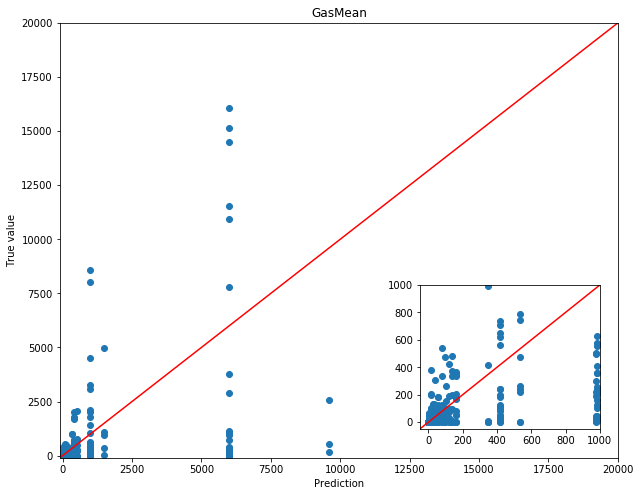

In [80]:
def parity_plot_real(actual, prediction, title):
    fig, ax = plt.subplots(figsize=(10,8))
    
    prediction = prediction.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    ax.scatter(prediction[mask], actual[mask])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = xlim
    if xlim[1] < ylim[1]:
        lim = ylim
    ax.plot(lim, lim, c='r')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')
    lim = [-100, 20000]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
    ax2 = fig.add_axes([0.625, 0.175, 0.25, 0.25])
    ax2.scatter(prediction[mask], actual[mask])
    ax2.set_xlim([-50, 1000])
    ax2.set_ylim([-50, 1000])
    ax2.plot(lim, lim, c='r')
    ax.set_title(title)
    plt.show()
    
parity_plot_real(henry_df, np.exp(best_U.T.dot(best_V)), 'RecSys')
means = np.nanmean(henry_df.values, axis=0)
prediction = np.zeros(henry_df.shape)
for (i, mean_i) in enumerate(means):
    prediction[:, i] = mean_i

parity_plot_real(henry_df, prediction, 'GasMean')

In [29]:
def LOO_cross_validation(henry_df, rs, lambd1s, lambd2s):
    min_test_error = np.inf
    best_U = np.array([])
    best_V = np.array([])
    non_nan_indices_i, non_nan_indices_j = np.where(~np.isnan(henry_df))
    for r in rs:
        for lambd1 in lambd1s:
            for lambd2 in lambd2s:
                print('-----------------------------------------\nStarting ALS with the following parameters:\nr = {}, lambda = [{:.2f}, {:.2f}]'.format(r, lambd1, lambd2))
                test_errors = []
                Us = []
                Vs = []
                log_henries = henry_df.copy()
                mask = np.greater(log_henries, 0., where=~np.isnan(log_henries))
                log_henries[mask] = np.log(log_henries[mask])
                for (non_nan_i, non_nan_j) in zip(non_nan_indices_i, non_nan_indices_j):
                    temp_log_henry = np.copy(log_henries)
                    temp_log_henry[non_nan_i, non_nan_j] = np.nan
                    U,V, train_error = ALS(temp_log_henry, r, [lambd1, lambd2], 1e-5, 1e-6, 10000, False)
                    pred = U.T.dot(V).flatten()
                    actual = temp_log_henry.flatten()
                    non_nan_mask = ~np.isnan(actual)
                    test_errors.append(np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(actual[non_nan_mask]))])/len(actual[non_nan_mask])))
                    Us.append(U)
                    Vs.append(V)
                test_error = np.mean(test_errors)
                print('Test Error: {:.3f}'.format(test_error))
                #print('Test Errors:\n\t{:.2f}\n\t{:.2f}\n\t{:.2f}\n'.format(test_errors[0], test_errors[1], test_errors[2]))
                if test_error < min_test_error:
                    min_test_error = test_error
                    print('\n^^^^^^^^^^^^^^^^^^^\n')
                    best_fold = np.argmin(test_errors)
                    best_U = np.copy(Us[best_fold])
                    best_V = np.copy(Vs[best_fold])
    return best_U, best_V

rs = [5]
lambd1s = [0.1]
lambd2s = [0.05]
best_U, best_V = LOO_cross_validation(henry_df, rs, lambd1s, lambd2s)
            

-----------------------------------------
Starting ALS with the following parameters:
r = 5, lambda = [0.10, 0.05]
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum number of iterations reached.
Maximum num

In [11]:
def predict_v3(x, y, mu):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + (x.T).dot(y)

In [12]:
def predict_all_v3(U, V, mu):
    predictions = np.zeros((U.shape[0], V.shape[1]))
    for u in range(U.shape[0]):
        for i in range(V.shape[1]):
            predictions[u, i] = predict_v3(U[u,:], V[:,i], mu)
    return predictions

U shape: (97, 20)	V shape: (20, 34)
Train Error on iteration 0: 1.3443236658675821
-------------
Train Error on iteration 1000: 0.00407114859959925
-------------
Training has converged after 1644 iterations. See `convergence` parameter for convergence procedure.
Train error: 0.0027242208113543876


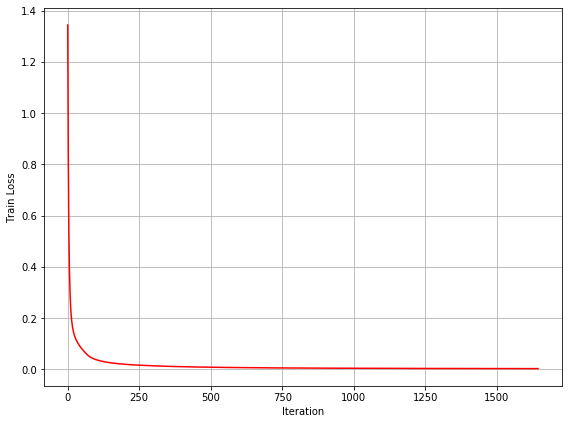

In [27]:
def WNMF(henry_matrix, r, threshold, convergence=1e-5, maxiter=100000, verbose=True):
    n_iter = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    n_convergence = 0
    n, m = henry_matrix.shape
    
    W = ~np.isnan(henry_matrix)
    U = np.random.rand(n, r)
    V = np.random.rand(r, m)
    WA = np.multiply(W, henry_matrix)
    WA[np.isnan(WA)] = 0.0

    print('U shape: {}\tV shape: {}'.format(U.shape, V.shape))
    while train_error > threshold:
        
        for j in range(r):
            # Move WUV #1 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(n):
                #WUV = np.multiply(W, np.matmul(U,V))
                U[i,j] = U[i,j] * (np.matmul(WA, np.transpose(V)))[i,j] / (np.matmul(WUV, np.transpose(V)))[i,j]
            # Move WUV #2 here?
            WUV = np.multiply(W, np.matmul(U,V))
            for i in range(m):
                #WUV = np.multiply(W, np.matmul(U,V))
                V[j,i] = V[j,i] * (np.matmul(np.transpose(U), WA))[j,i] / (np.matmul(np.transpose(U), WUV))[j,i] 
            
            if any(np.isnan(U.flatten())):
                raise Exception('''nan's in U''')
            if any(np.isnan(V.flatten())):
                raise Exception('''nan's in V''')
        
        pred = predict_all_v3(U, V, 0.0)[W].flatten()
        actual = henry_matrix[W].flatten()
        
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n_iter % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n_iter, train_error))
            
        if error_diff < convergence:
            n_convergence += 1
            if n_convergence > 999:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n_iter))
                print('Train error: {}'.format(train_error))
                break
        else:
            n_convergence = 0
        n_iter += 1
        if n_iter > maxiter:
            print('Maximum number of iterations reached.')
            break
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.grid('on')
    plt.tight_layout()
    plt.show()
    
    return U, V
mu = np.nanmean(henry_df.values)
norm_factors = np.nanmean(henry_df.values, axis=0)

U2, V2 = WNMF(henry_df.values/norm_factors, 20, 1e-5)

In [28]:
h = np.matmul(U2,V2) * norm_factors
#i = random.choice(np.arange(henry_df.shape[0]))
#j = random.choice(np.arange(henry_df.shape[1]))
_i,_j = np.where(np.isnan(henry_df.values))
for _ in range(10):
    idx = random.choice(np.arange(len(_i)))
    i = _i[idx]
    j = _j[idx]
    print('Adsorption of {} in {}'.format(key_to_gas[henry_df.columns[j].split('_')[0]], key_to_material[henry_df.index[i]]))
    print('Prediction: {:.3f}'.format(h[i,j]))
    print('Actual value: {:.3f}\n'.format(henry_df.values[i,j]))

Adsorption of Propene in [Zn(bdc)(ted)0.5]*2DMF*0.2H2O
Prediction: 63.545
Actual value: nan

Adsorption of Hydrogen in [Co2(ndc)2(bpy)]
Prediction: 0.742
Actual value: nan

Adsorption of Sulfur Hexafluoride in {[Zn2(H2dht)(dht)0.5)(azpy)0.5]}
Prediction: 1.907
Actual value: nan

Adsorption of Krypton in MIL-101
Prediction: 27.982
Actual value: nan

Adsorption of Acetylene in Carbon
Prediction: 106.411
Actual value: nan

Adsorption of Isobutane in Zn-MOF-74
Prediction: 504.570
Actual value: nan

Adsorption of Sulfur Hexafluoride in COF-105
Prediction: 37.268
Actual value: nan

Adsorption of Ethene in COF-105
Prediction: 504.342
Actual value: nan

Adsorption of Ethanol in Co3(HCOO)6
Prediction: 468.183
Actual value: nan

Adsorption of N-Hexane in MCM-41
Prediction: 61.226
Actual value: nan



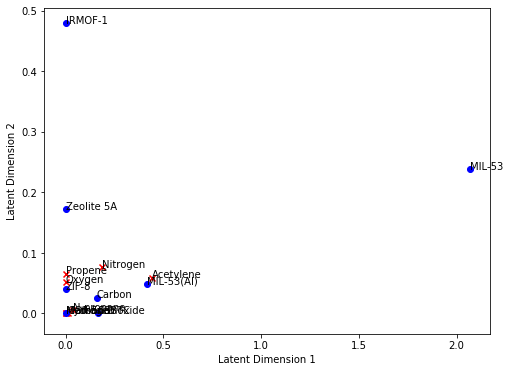

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
n = 8
ax.scatter(U2[:n, 0], U2[:n, 1], color='red', marker='x')
ax.scatter(V2[0,:n], V2[1,:n], color='blue', marker='o')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

for i in range(n):
    ax.text(U2[i,0], U2[i,1], key_to_gas[henry_df.columns[i].split('_')[0]])
    ax.text(V2[0,i], V2[1,i], key_to_material[henry_df.index[i]])
plt.show()

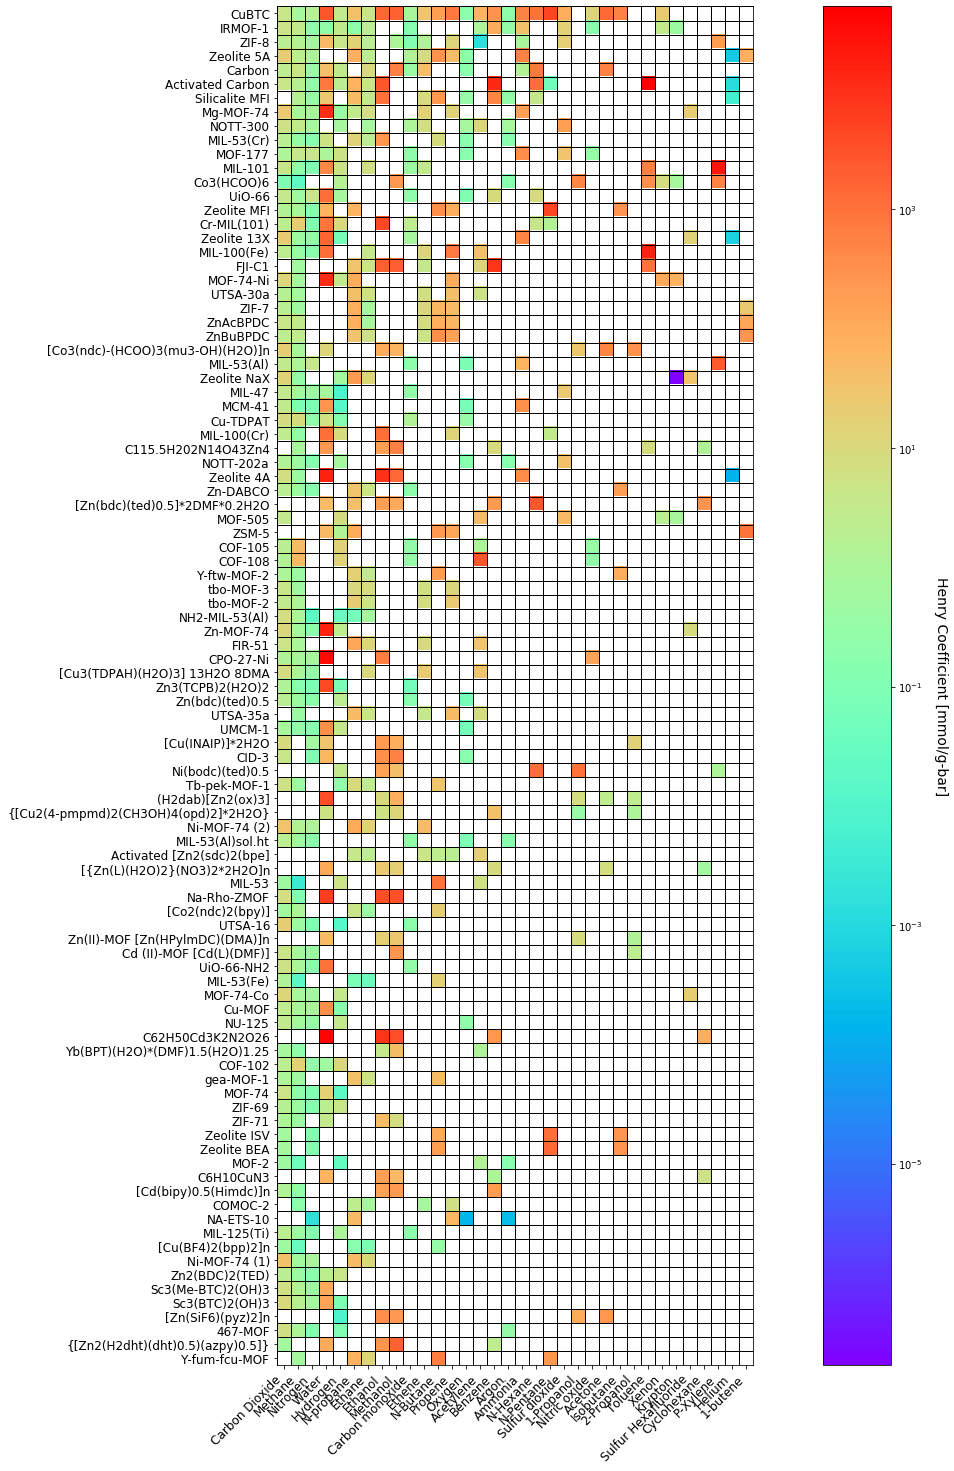

In [31]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1, color='k')

plt.imshow(henry_df.values[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(henry_df.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(henry_df.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

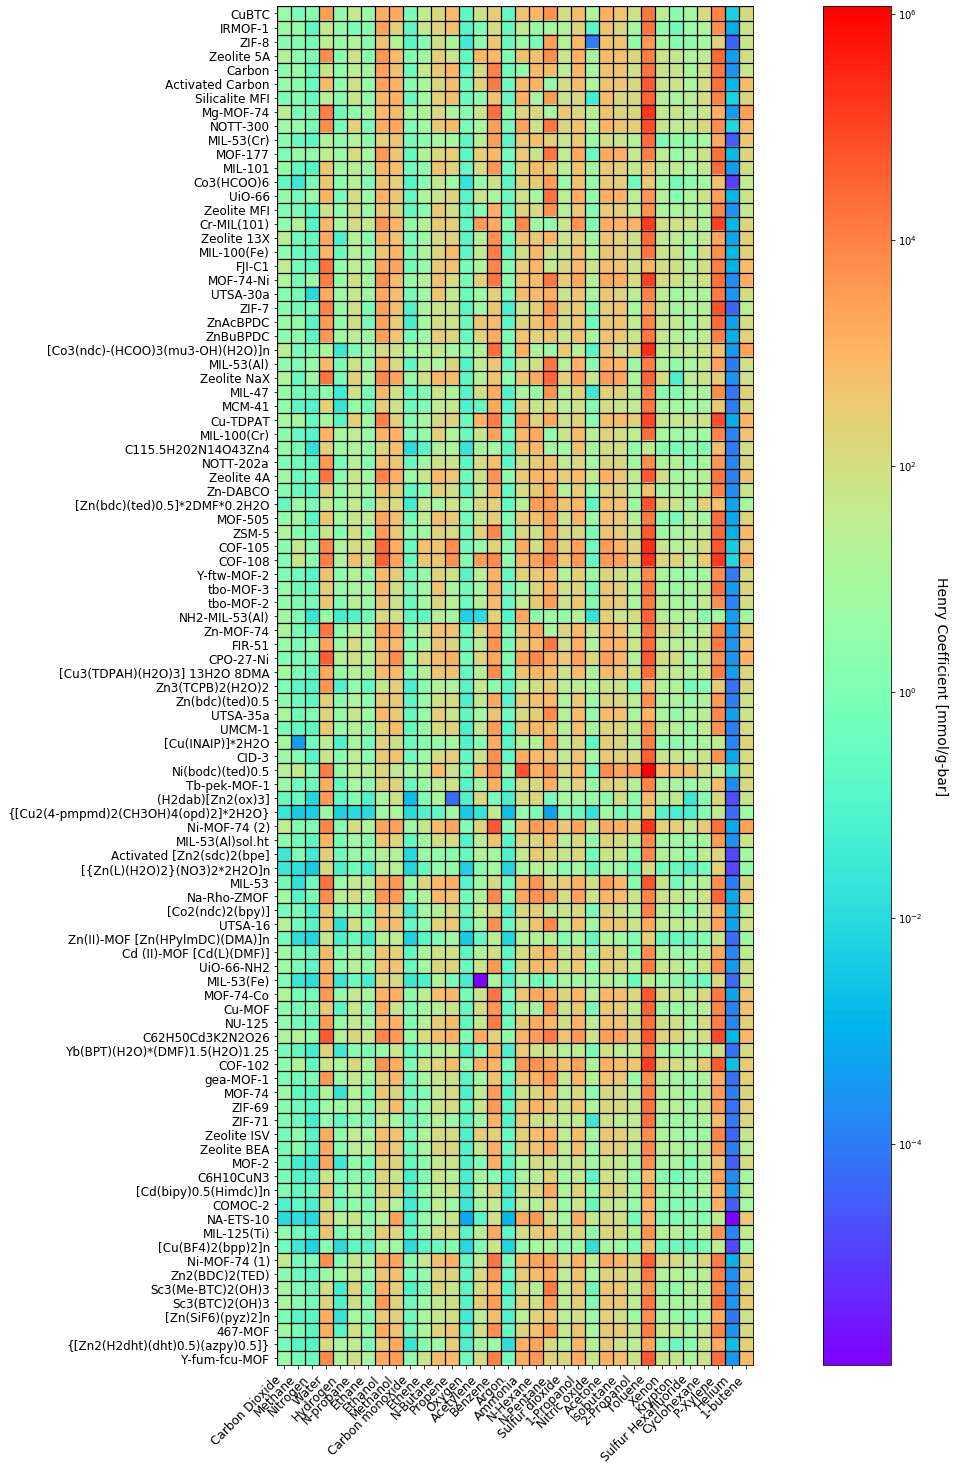

In [32]:
fig = plt.figure(figsize=(25,25))
ax = plt.gca()

for y in range(henry_df.shape[0]):
    plt.plot([0-0.5, henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(h.shape[1]))
ax.set_xticklabels([key_to_gas[henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(h.shape[0]))
ax.set_yticklabels([key_to_material[henry_df.index[i]] for i in new_row_order], fontsize=12)

plt.show()

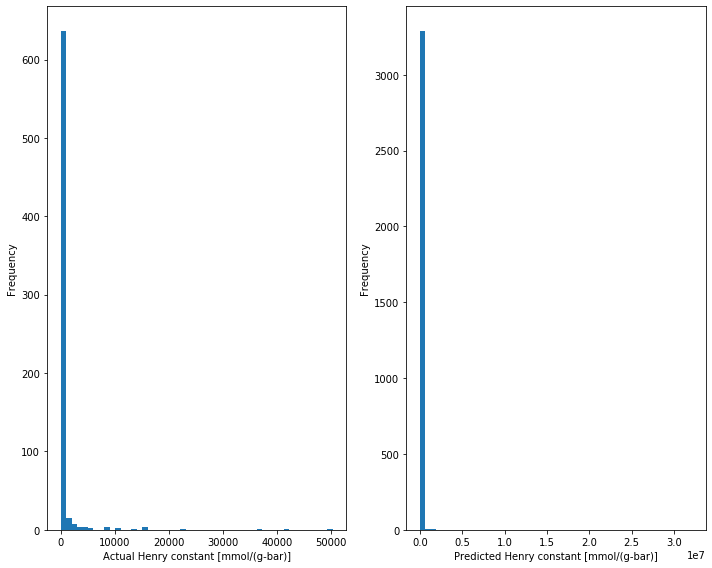

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(10,8))
axs[0].hist(henry_df.values[~np.isnan(henry_df)].flatten(), bins=50)
axs[0].set_xlabel('Actual Henry constant [mmol/(g-bar)]')
axs[0].set_ylabel('Frequency')

axs[1].hist(h.flatten(), bins=50)
axs[1].set_xlabel('Predicted Henry constant [mmol/(g-bar)]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
max_ind = np.unravel_index(np.argmax(h, axis=None), h.shape)

gas = key_to_gas[henry_df.columns[max_ind[1]].split('_')[0]]
material = key_to_material[henry_df.index[max_ind[0]]]
print('Biggest prediction is {:.2f} mmol/(g-bar)\nGas: {}, Material: {}'.format(h[max_ind], gas, material))


Biggest prediction is 32108648.45 mmol/(g-bar)
Gas: Toluene, Material: COF-108
